## Hierarchical Clustering Implementation

In [105]:
# importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import warnings
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist, squareform
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

In [106]:
# loading the dataset
df = pd.read_csv('lipinski_balanced_smote.csv')

In [107]:
# define features
feature_cols = ['MolWt', 'LogP', 'NumHDonors', 'NumHAcceptors', 'TPSA', 'NumRotatableBonds']
X = df[feature_cols].values
lipinski_labels = df['Lipinski_Pass'].values

In [108]:
df.shape

(20392, 7)

In [109]:
print("The data below is standardized in the EDA file:\n")
df.head()

The data below is standardized in the EDA file:



,MolWt,LogP,NumHDonors,NumHAcceptors,TPSA,NumRotatableBonds,Lipinski_Pass
0,1.629652,-1.059655,1.491575,1.855776,2.038806,2.477233,0.0
1,1.699947,-0.334259,1.491575,1.249972,1.576542,2.788072,0.0
2,1.361246,-0.468688,1.491575,1.249972,1.576542,2.788072,0.0
3,1.640575,-0.091589,1.491575,1.249972,1.576542,2.477233,0.0
4,0.308036,0.690573,-0.002482,0.038366,0.273672,0.612200,1.0


In [110]:
# calculating complete linkage
Z_complete = linkage(X, method='complete', metric='euclidean')

# getting distance statistics
max_distance = Z_complete[:, 2].max()
min_distance = Z_complete[:, 2].min()

# calculating 70% threshold
threshold = 0.7 * max_distance

Note: Dendrogram display truncated to last 50 merges for clarity (full data still used)



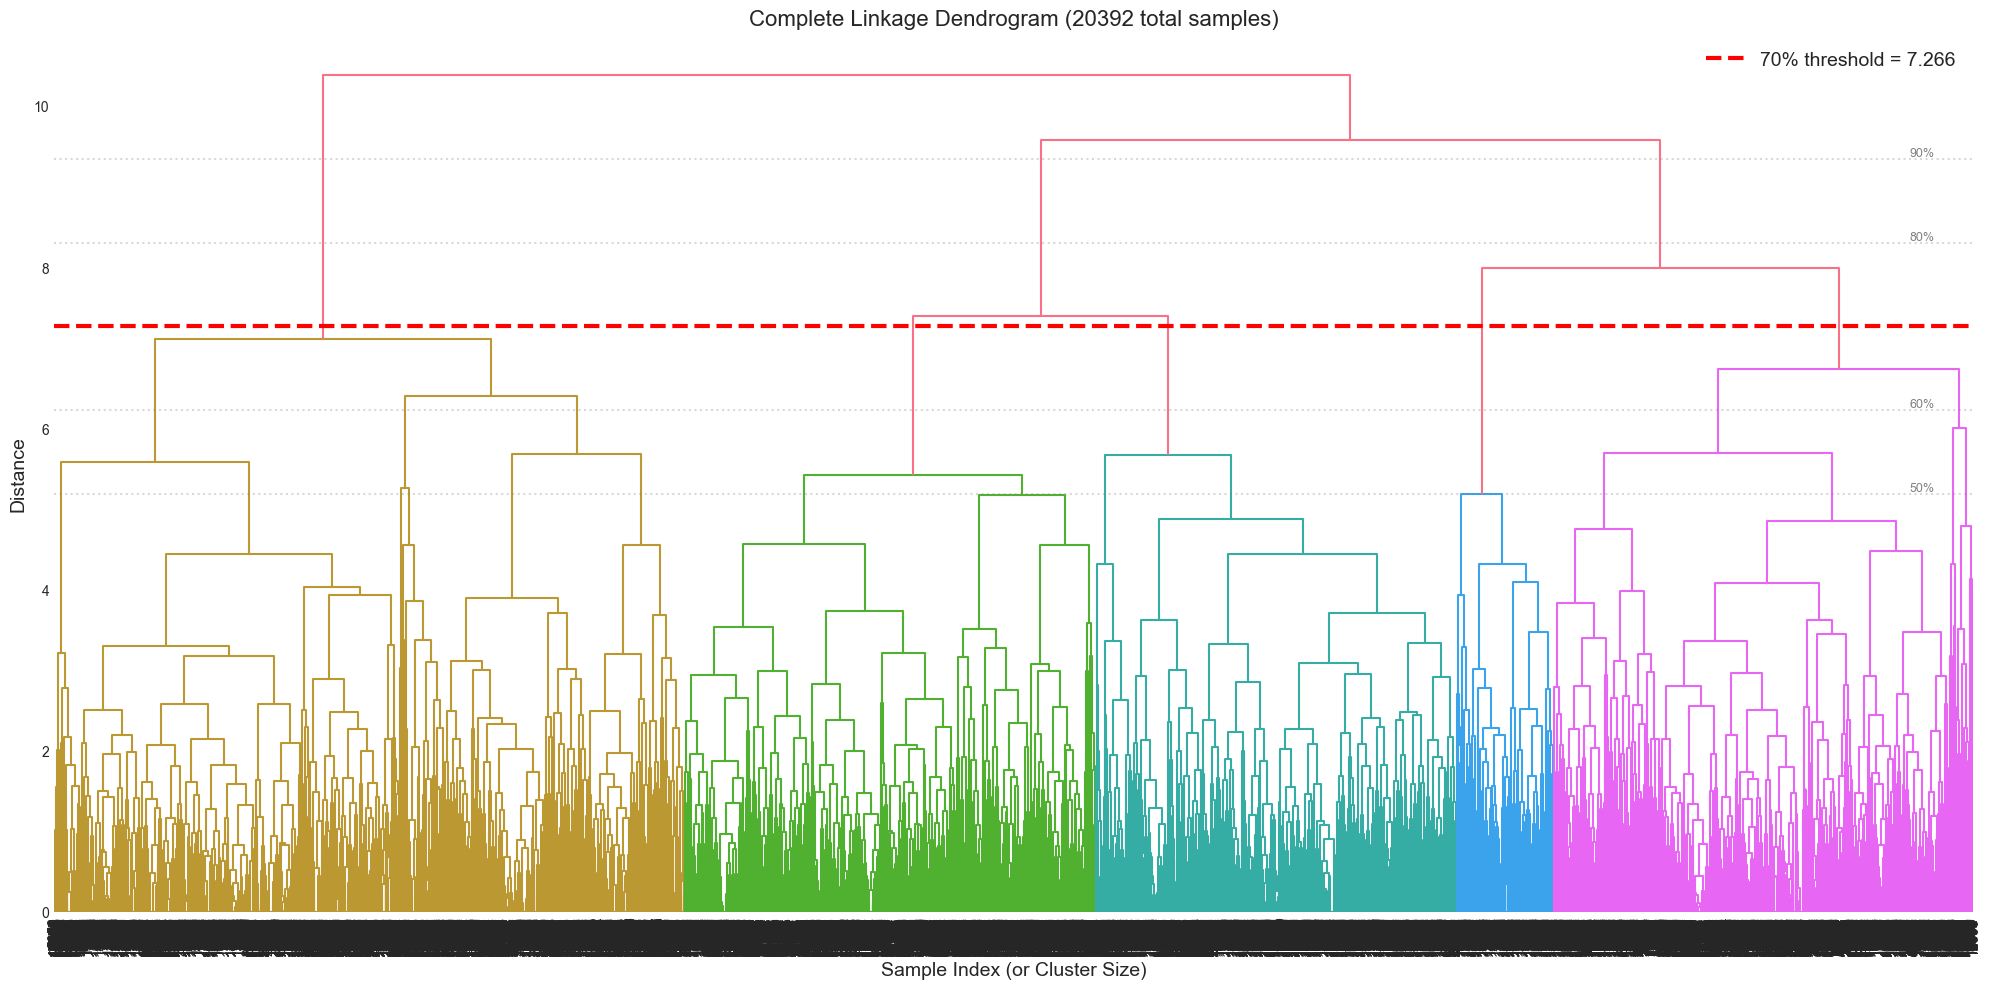

In [111]:
# plotting the dendrogram
def plot_dendrogram(Z, threshold):
    plt.figure(figsize=(20, 10))
    n_samples = Z.shape[0] + 1
    if n_samples > 1000:
        print(f"Note: Dendrogram display truncated to last 50 merges for clarity (full data still used)\n")
        p_value = 50
    else:
        p_value = 30
    
    # create dendrogram
    dendro = dendrogram(Z, 
                       truncate_mode='level',
                       p=p_value,
                       show_leaf_counts=True,
                       leaf_font_size=10,
                       color_threshold=threshold)  # color by 70% threshold
    
    # adding 70% threshold line
    plt.axhline(y=threshold, c='red', linestyle='--', linewidth=3, 
               label=f'70% threshold = {threshold:.3f}')
    
    # adding reference lines
    y_max = Z[:, 2].max()
    for pct, color in zip([0.5, 0.6, 0.8, 0.9], ['gray', 'gray', 'gray', 'gray']):
        plt.axhline(y=pct * y_max, c=color, linestyle=':', alpha=0.3)
        plt.text(plt.xlim()[1] * 0.98, pct * y_max, f'{int(pct*100)}%', 
                ha='right', va='bottom', color='gray', fontsize=9)
    
    plt.xlabel('Sample Index (or Cluster Size)', fontsize=14)
    plt.ylabel('Distance', fontsize=14)
    plt.title(f'Complete Linkage Dendrogram ({n_samples} total samples)', fontsize=16)
    plt.legend(loc='upper right', fontsize=14)
    plt.grid(True, axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# final dendrogram plot
plot_dendrogram(Z_complete, threshold)

In [112]:
# cutting dendrogram 
cluster_labels = fcluster(Z_complete, threshold, criterion='distance') - 1

# adding to dataframe
df['Cluster'] = cluster_labels

# get clustering statistics
unique_labels, counts = np.unique(cluster_labels, return_counts=True)
n_clusters = len(unique_labels)
sorted_indices = np.argsort(counts)[::-1]

print("Cluster sizes:\n")
for idx in sorted_indices[:20]: # top 20 clusters
    label = unique_labels[idx]
    count = counts[idx]
    print(f"Cluster {label}: {count} samples ({count/len(cluster_labels)*100:.1f}%)")

Cluster sizes:

Cluster 0: 6807 samples (33.4%)
Cluster 4: 4421 samples (21.7%)
Cluster 1: 4337 samples (21.3%)
Cluster 2: 3812 samples (18.7%)
Cluster 3: 1015 samples (5.0%)


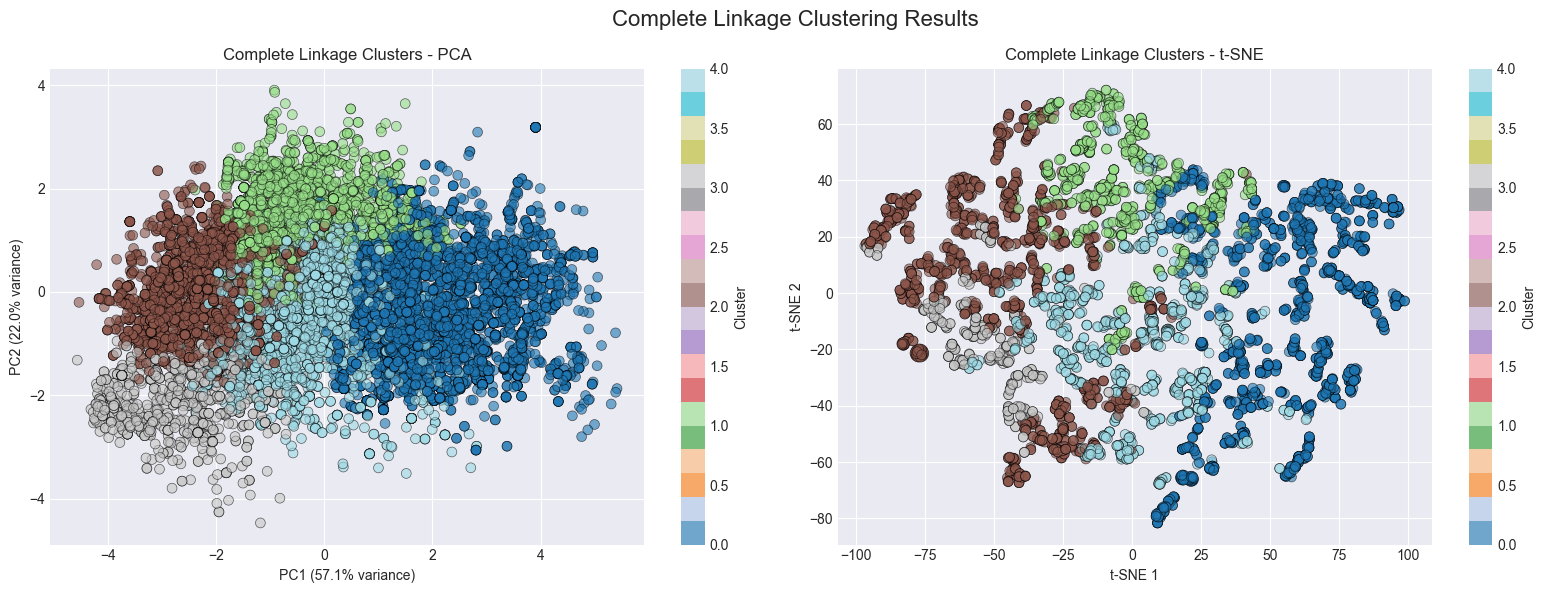

In [113]:
# visualizing clusters - PCA and t-SNE

def visualize_clusters(X, labels):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # PCA visualization
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X)
    ax1 = axes[0]
    scatter1 = ax1.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='tab20', 
                          alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
    ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
    ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
    ax1.set_title('Complete Linkage Clusters - PCA')
    plt.colorbar(scatter1, ax=ax1, label='Cluster')
    
    # t-SNE visualization
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
    X_tsne = tsne.fit_transform(X[:5000] if len(X) > 5000 else X)
    labels_tsne = labels[:5000] if len(X) > 5000 else labels
    ax2 = axes[1]
    scatter2 = ax2.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels_tsne, cmap='tab20', 
                          alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
    ax2.set_xlabel('t-SNE 1')
    ax2.set_ylabel('t-SNE 2')
    ax2.set_title('Complete Linkage Clusters - t-SNE')
    plt.colorbar(scatter2, ax=ax2, label='Cluster')
    
    plt.suptitle('Complete Linkage Clustering Results', fontsize=16)
    plt.tight_layout()
    plt.show()

# visualize clusters
visualize_clusters(X, cluster_labels)

In [114]:
# analyzing cluster characteristics
def analyze_clusters(df, feature_cols, cluster_col='Cluster'):
    summary_data = []
    
    # sorting clusters by size 
    cluster_sizes = df[cluster_col].value_counts().sort_values(ascending=False)
    
    for i, cluster_id in enumerate(cluster_sizes.index[:15]):
        cluster_data = df[df[cluster_col] == cluster_id]
        
        print(f"\nCLUSTER {cluster_id} ({len(cluster_data)} samples, {len(cluster_data)/len(df)*100:.1f}%):")
        print("-" * 40)
        
        summary = {
            'Cluster': cluster_id,
            'Size': len(cluster_data),
            'Size_pct': len(cluster_data) / len(df) * 100
        }
        
        # feature statistics
        print("Feature means ± std:")
        for feat in feature_cols:
            mean_val = cluster_data[feat].mean()
            std_val = cluster_data[feat].std()
            print(f"  {feat}: {mean_val:.3f} ± {std_val:.3f}")
            summary[f'{feat}_mean'] = mean_val
            summary[f'{feat}_std'] = std_val
        
        # Lipinski analysis
        if 'Lipinski_Pass' in cluster_data.columns:
            lipinski_pass_rate = cluster_data['Lipinski_Pass'].mean() * 100
            print(f"\nLipinski Pass Rate: {lipinski_pass_rate:.1f}%")
            summary['Lipinski_Pass_Rate'] = lipinski_pass_rate
        
        summary_data.append(summary)
    
    if len(cluster_sizes) > 15:
        print(f"\n... and {len(cluster_sizes) - 15} more smaller clusters")
    
    return pd.DataFrame(summary_data)

# analyzing clusters
cluster_summary = analyze_clusters(df, feature_cols)


CLUSTER 0 (6807 samples, 33.4%):
----------------------------------------
Feature means ± std:
  MolWt: 0.879 ± 0.643
  LogP: -0.618 ± 0.801
  NumHDonors: 1.053 ± 0.803
  NumHAcceptors: 0.716 ± 0.737
  TPSA: 1.172 ± 0.562
  NumRotatableBonds: 0.997 ± 0.825

Lipinski Pass Rate: 35.1%

CLUSTER 4 (4421 samples, 21.7%):
----------------------------------------
Feature means ± std:
  MolWt: 0.133 ± 0.863
  LogP: 0.002 ± 0.769
  NumHDonors: 0.029 ± 0.735
  NumHAcceptors: 0.096 ± 0.732
  TPSA: 0.092 ± 0.537
  NumRotatableBonds: -0.166 ± 0.761

Lipinski Pass Rate: 63.9%

CLUSTER 1 (4337 samples, 21.3%):
----------------------------------------
Feature means ± std:
  MolWt: 0.608 ± 0.541
  LogP: 1.185 ± 0.591
  NumHDonors: -0.699 ± 0.496
  NumHAcceptors: 0.473 ± 0.841
  TPSA: -0.233 ± 0.487
  NumRotatableBonds: 0.084 ± 0.723

Lipinski Pass Rate: 26.7%

CLUSTER 2 (3812 samples, 18.7%):
----------------------------------------
Feature means ± std:
  MolWt: -0.713 ± 0.608
  LogP: 0.669 ± 0.695
  

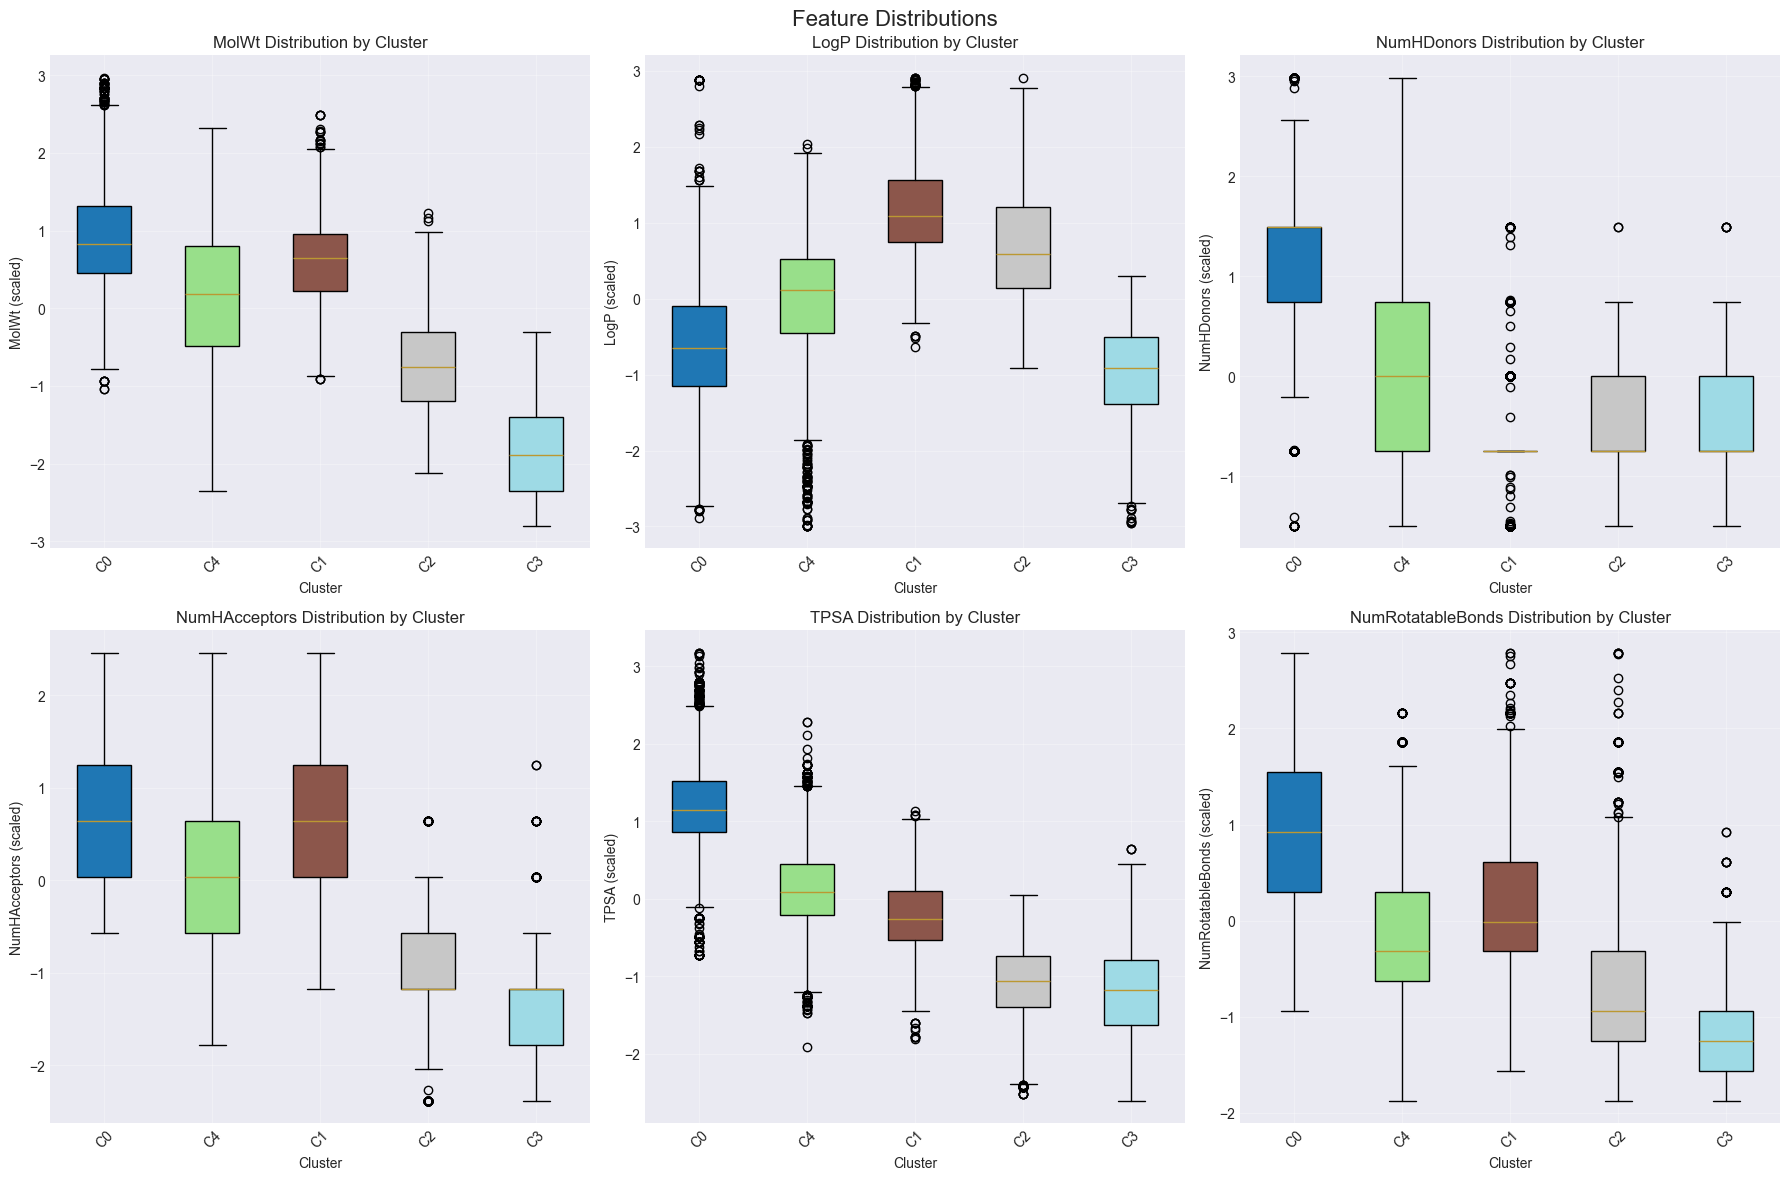

In [115]:
# feature distribution box plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()
top_clusters = df['Cluster'].value_counts().head(12).index

for idx, feature in enumerate(feature_cols):
    ax = axes[idx]
    
    # preparing data for top clusters only
    cluster_feature_data = []
    cluster_labels_plot = []
    
    for cluster_id in top_clusters:
        data = df[df['Cluster'] == cluster_id][feature].values
        cluster_feature_data.append(data)
        cluster_labels_plot.append(f'C{cluster_id}')
    
    # creating box plot
    bp = ax.boxplot(cluster_feature_data, labels=cluster_labels_plot, patch_artist=True)
    colors = plt.cm.tab20(np.linspace(0, 1, len(bp['boxes'])))
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    
    ax.set_xlabel('Cluster')
    ax.set_ylabel(f'{feature} (scaled)')
    ax.set_title(f'{feature} Distribution by Cluster')
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

plt.suptitle('Feature Distributions', fontsize=16)
plt.tight_layout()
plt.show()

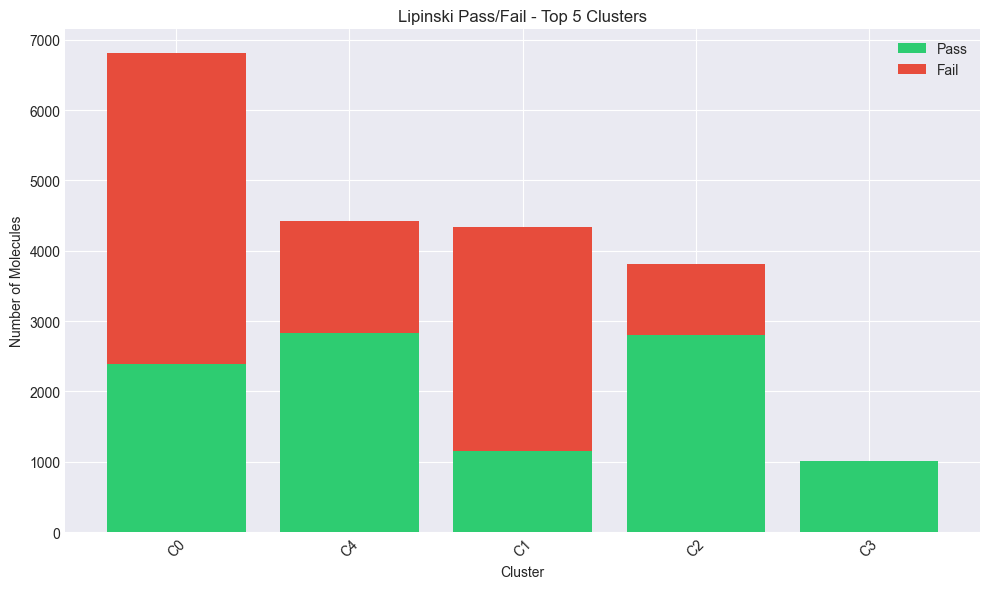

In [116]:
# plotting stacked bar chart for lipinski pass or fail
def plot_lipinski_pass_fail(df, max_clusters_shown=15):
    import matplotlib.pyplot as plt

    top_clusters = df['Cluster'].value_counts().head(max_clusters_shown).index
    lipinski_data = []

    for cluster in top_clusters:
        cluster_data = df[df['Cluster'] == cluster]
        pass_count = cluster_data['Lipinski_Pass'].sum()
        total_count = len(cluster_data)
        fail_count = total_count - pass_count

        lipinski_data.append({
            'Cluster': cluster,
            'Pass_Count': pass_count,
            'Fail_Count': fail_count
        })

    lipinski_df = pd.DataFrame(lipinski_data)
    clusters = range(len(lipinski_df))
    width = 0.8

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(clusters, lipinski_df['Pass_Count'], width, label='Pass', color='#2ecc71')
    ax.bar(clusters, lipinski_df['Fail_Count'], width, bottom=lipinski_df['Pass_Count'],
           label='Fail', color='#e74c3c')
    ax.set_xlabel('Cluster')
    ax.set_ylabel('Number of Molecules')
    ax.set_title(f'Lipinski Pass/Fail - Top {len(lipinski_df)} Clusters')
    ax.set_xticks(clusters)
    ax.set_xticklabels([f'C{c}' for c in lipinski_df['Cluster']], rotation=45)
    ax.legend()
    plt.tight_layout()
    plt.show()
plot_lipinski_pass_fail(df)

In [117]:
# Lipinski Pass Rate Summary
def summarize_lipinski_pass_rate(df, max_clusters_shown=15):
    import pandas as pd

    top_clusters = df['Cluster'].value_counts().head(max_clusters_shown).index
    lipinski_data = []

    for cluster in top_clusters:
        cluster_data = df[df['Cluster'] == cluster]
        pass_count = cluster_data['Lipinski_Pass'].sum()
        total_count = len(cluster_data)
        pass_rate = (pass_count / total_count) * 100

        lipinski_data.append({
            'Cluster': cluster,
            'Size': total_count,
            'Pass_Count': pass_count,
            'Fail_Count': total_count - pass_count,
            'Pass_Rate (%)': round(pass_rate, 2)
        })

    lipinski_df = pd.DataFrame(lipinski_data)

    print("Lipinski Pass Rate Summary:\n")
    print(lipinski_df.to_string(index=False))

    return lipinski_df

lipinski_summary = summarize_lipinski_pass_rate(df)

Lipinski Pass Rate Summary:

 Cluster  Size  Pass_Count  Fail_Count  Pass_Rate (%)
       0  6807      2390.0      4417.0          35.11
       4  4421      2827.0      1594.0          63.94
       1  4337      1157.0      3180.0          26.68
       2  3812      2807.0      1005.0          73.64
       3  1015      1015.0         0.0         100.00


In [118]:
# evaluating cluster quality
print("Evaluating clustering quality:\n")

silhouette = silhouette_score(X, cluster_labels)
print(f"Silhouette Score: {silhouette:.3f}")

calinski = calinski_harabasz_score(X, cluster_labels)
print(f"Calinski-Harabasz Score: {calinski:.2f}")

davies_bouldin = davies_bouldin_score(X, cluster_labels)
print(f"Davies-Bouldin Score: {davies_bouldin:.3f}")

Evaluating clustering quality:

Silhouette Score: 0.155
Calinski-Harabasz Score: 6172.49
Davies-Bouldin Score: 1.660
